In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

# Object detection with Yolo

This notebook has been written following this post:<br>
https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html

# List of existing yolo models

* Yolov1: https://pjreddie.com/media/files/yolo.weights (194 MB)
* Yolov2: https://pjreddie.com/media/files/yolov2.weights (194 MB)
* Yolo9000: https://pjreddie.com/media/files/yolo9000.weights (186 MB)
* Yolov3: https://pjreddie.com/media/files/yolov3.weights (237 MB)
* Yolo-tiny: https://pjreddie.com/media/files/yolov3-tiny.weights (33.8 MB)

# Yolo networks configuration files

The yolo-nets configurations are available at: https://github.com/pjreddie/darknet/tree/master/cfg

For the models listed above:

* Yolov1: https://github.com/pjreddie/darknet/tree/master/cfg/yolov1.cfg
* Yolov2: https://github.com/pjreddie/darknet/tree/master/cfg/yolov2.cfg
* Yolo9000: https://github.com/pjreddie/darknet/tree/master/cfg/yolov9000.cfg
* Yolov3: https://github.com/pjreddie/darknet/tree/master/cfg/yolov3.cfg
* Yolov3-tiny: https://github.com/pjreddie/darknet/tree/master/cfg/yolov3-tiny.cfg

# Yolo labels

The labels are https://github.com/pjreddie/darknet/tree/master/data/coco.names for Yolov1, Yolov2, Yolov3 and Yolov3-tiny.

The labels are https://github.com/pjreddie/darknet/tree/master/data/9k.names for Yolo9000

# Let's make a test with Yolov3

In [38]:
# Downloading files
# ! wget https://pjreddie.com/media/files/yolov3.weights
# ! wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
# ! wget https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names
# ! wget https://pjreddie.com/media/files/yolov3-tiny.weights
# ! wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg

--2019-09-13 19:58:51--  https://pjreddie.com/media/files/yolov3-tiny.weights
Résolution de pjreddie.com (pjreddie.com)… 128.208.4.108
Connexion à pjreddie.com (pjreddie.com)|128.208.4.108|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 35434956 (34M) [application/octet-stream]
Enregistre : «yolov3-tiny.weights»

yolov3-tiny.weights 100%[===================>]  33,79M   505KB/s    ds 3m 1s   

2019-09-13 20:01:56 (191 KB/s) - «yolov3-tiny.weights» enregistré [35434956/35434956]

--2019-09-13 20:01:56--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 1915 (1,9K) [text/plain]
Enregistre : «yolov3-tiny.cfg»

yolov3-tiny.cfg     100%[===========

In [46]:
# read class names from text file
classes = None
with open("coco.names", 'r') as f:
    classes = [line.strip() for line in f.readlines()]
    
# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")

In [47]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

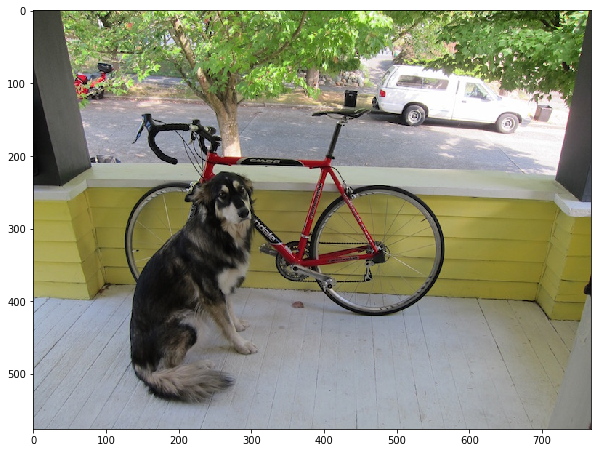

In [48]:
def draw_img(img_path):
    img_raw = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb);
    
draw_img("dog.jpg")

In [49]:
def obj_detect(img_file, yolonet):
    image = cv2.imread(img_file)
    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392
    # create input blob 
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)
    # set input blob for the network
    yolonet.setInput(blob)
    # run inference through the network and gather predictions from output layers
    outs = yolonet.forward(get_output_layers(yolonet))

    # initialization
    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4

    # for each detetion from each output layer 
    # get the confidence, class id, bounding box params
    # and ignore weak detections (confidence < 0.5)
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])
    
    # apply non-max suppression
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    # go through the detections remaining
    # after nms and draw bounding box
    for i in indices:
        i = i[0]
        box = boxes[i]
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]

        draw_bounding_box(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     img_rgb = image
    plt.figure(figsize=(15, 15))
    plt.imshow(img_rgb);


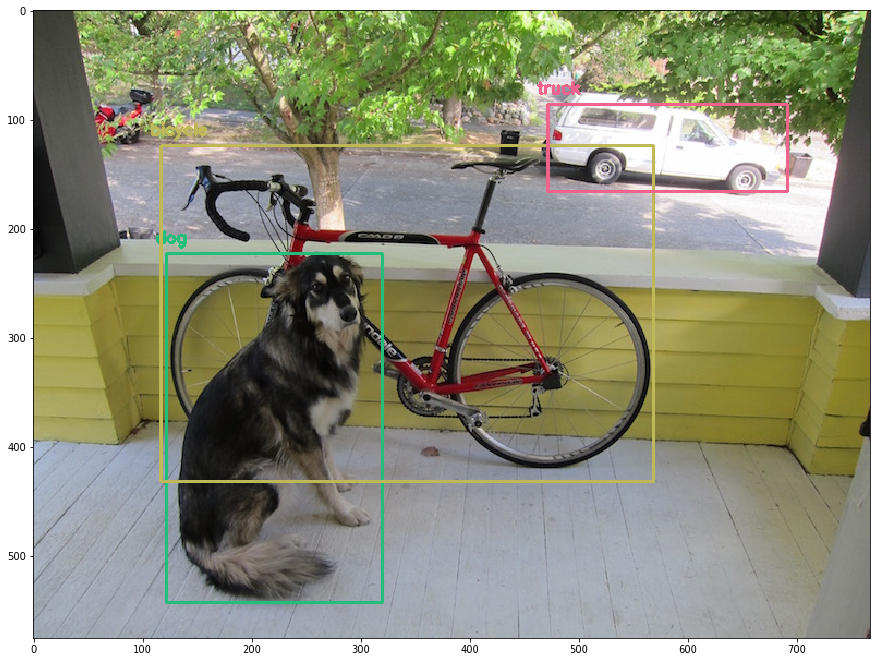

In [50]:
obj_detect("dog.jpg", net)

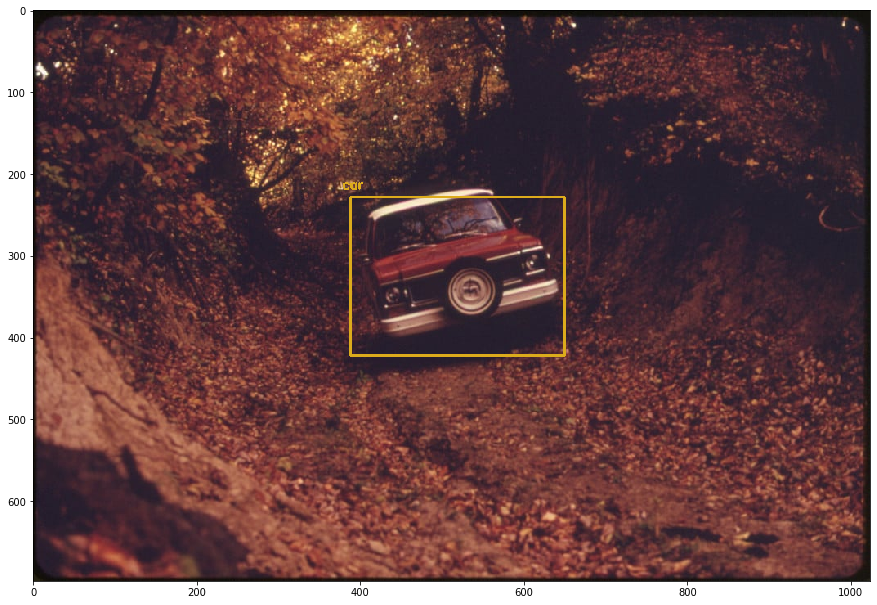

In [51]:
obj_detect("car.jpg", net)

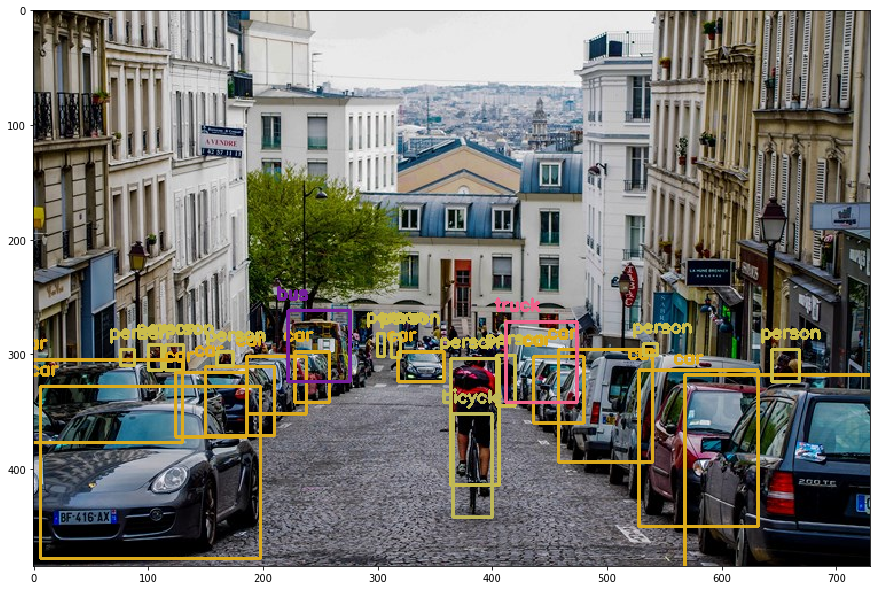

In [52]:
obj_detect("street.jpg", net)

In [53]:
# release resources
cv2.destroyAllWindows()